## Deep Learning For NLP: Zero To Transformers & BERT

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
# from keras.layers.normalization import BatchNormalization
# from keras.layers.
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
# from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

ModuleNotFoundError: No module named 'plotly'

In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
train = pd.read_csv('/Users/richardwanjohi/DL/jigsaw-toxic-comment-train.csv')

In [5]:
train.shape

(223549, 8)

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test = pd.read_csv('/Users/richardwanjohi/DL/test-1.csv')

In [7]:
test.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [7]:
validation = pd.read_csv('/Users/richardwanjohi/DL/validation.csv')
validation.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [8]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [9]:
train.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [10]:
train = train.loc[:12000,:]
train.shape

(12001, 3)

In [11]:
#check the maximum number of words that can be present in a comment , this will help us in padding later
train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [12]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [13]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

### Simple RNN

In [14]:
# using keras tokenizer here
token = Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

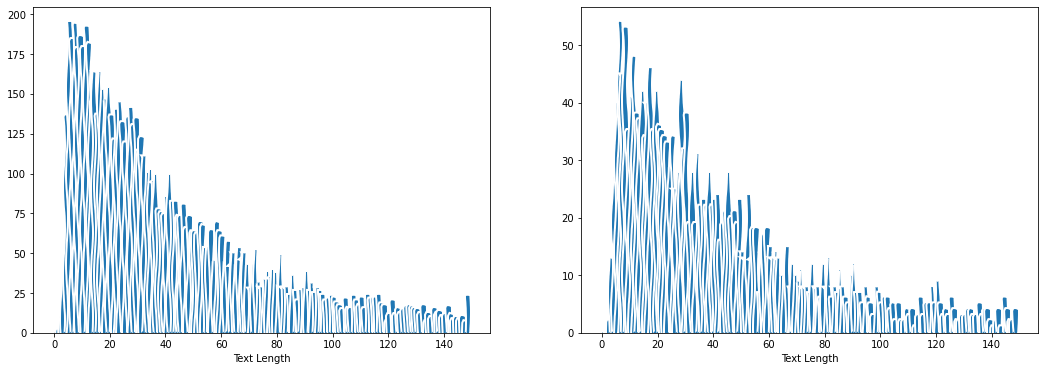

In [15]:
plt.rcParams['figure.figsize'] = [18, 6]
lengths = [len(x) for x in xtrain_seq]
plt.subplot(1, 2, 1)
with plt.xkcd():
    plt.hist(lengths, bins = range(150))
    #plt.title('Texts Length Distribution')
    #plt.ylabel('Loss')
    plt.xlabel('Text Length')
 

plt.subplot(1, 2, 2)
lengths = [len(x) for x in xvalid_seq]

with plt.xkcd():
    plt.hist(lengths, bins = range(150))
    #plt.title('Texts Length Distribution')
    #plt.ylabel('Loss')
    plt.xlabel('Text Length')

In [32]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

2022-05-06 21:11:29.850148: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         13049100  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 13,089,301
Trainable params: 13,089,301
Non-trainable params: 0
_________________________________________________________________
CPU times: user 253 ms, sys: 174 ms, total: 427 ms
Wall time: 388 ms


In [34]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync) 

Epoch 1/5
150/150 [==============================] - 124s 818ms/step - loss: 0.2925 - accuracy: 0.9071
Epoch 2/5
150/150 [==============================] - 119s 794ms/step - loss: 0.1390 - accuracy: 0.9509
Epoch 3/5
150/150 [==============================] - 119s 793ms/step - loss: 0.0263 - accuracy: 0.9922
Epoch 4/5
150/150 [==============================] - 118s 789ms/step - loss: 0.0290 - accuracy: 0.9912
Epoch 5/5
150/150 [==============================] - 118s 787ms/step - loss: 0.0029 - accuracy: 0.9995


In [35]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.85%


In [36]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,yvalid)})

In [37]:
scores_model

[{'Model': 'SimpleRNN', 'AUC_Score': 0.8460399028972762}]

In [18]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/Users/richardwanjohi/DL/Glove/glove.6B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:34, 11560.02it/s]

Found 400000 word vectors.


In [19]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|███████████████████████████████| 43496/43496 [00:00<00:00, 109141.61it/s]


In [42]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1500, 300)         13049100  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 13,209,601
Trainable params: 160,501
Non-trainable params: 13,049,100
_________________________________________________________________
CPU times: user 323 ms, sys: 239 ms, total: 562 ms
Wall time: 462 ms


In [43]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
150/150 [==============================] - 375s 2s/step - loss: 0.2273 - accuracy: 0.9205
Epoch 2/5
150/150 [==============================] - 2246s 15s/step - loss: 0.1583 - accuracy: 0.9429
Epoch 3/5
150/150 [==============================] - 2622s 18s/step - loss: 0.1577 - accuracy: 0.9411
Epoch 4/5
150/150 [==============================] - 2169s 15s/step - loss: 0.1313 - accuracy: 0.9500
Epoch 5/5
150/150 [==============================] - 4831s 32s/step - loss: 0.1310 - accuracy: 0.9529


In [44]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.97%


In [45]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores,yvalid)})
scores_model

[{'Model': 'SimpleRNN', 'AUC_Score': 0.8460399028972762},
 {'Model': 'LSTM', 'AUC_Score': 0.967624995440711}]

## GRU Gated Reccurent Unit

In [20]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
             300,
             weights=[embedding_matrix],
             input_length=max_len,
             trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         13049100  
                                                                 
 spatial_dropout1d (SpatialD  (None, 1500, 300)        0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 300)               540900    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 13,590,301
Trainable params: 541,201
Non-trainable params: 13,049,100
_________________________________________________________________


In [22]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
150/150 [==============================] - 3378s 23s/step - loss: 0.2284 - accuracy: 0.9232
Epoch 2/5
150/150 [==============================] - 6701s 45s/step - loss: 0.1566 - accuracy: 0.9447
Epoch 3/5
150/150 [==============================] - 6238s 42s/step - loss: 0.1250 - accuracy: 0.9539
Epoch 4/5
150/150 [==============================] - 1281s 9s/step - loss: 0.1073 - accuracy: 0.9609
Epoch 5/5
 93/150 [=================>............] - ETA: 7:51 - loss: 0.0965 - accuracy: 0.9662

KeyboardInterrupt: 